In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-15 17:20:49.217810: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/drive0-storage/Gracia/Dataset/dataset_5/training"
val_path = "/drive0-storage/Gracia/Dataset/dataset_5/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-15 17:20:51.439383: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 17:20:52.213827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38215 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:0f:00.0, compute capability: 8.0


Found 16332 files belonging to 3 classes.
Found 4080 files belonging to 3 classes.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


In [ ]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[31]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [9]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [10]:
print(len(validation_dataset))
print(len(test_dataset))

64
64


## Model building

In [11]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [12]:
with tf.device("GPU"):
    model = build_vgg16()
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [13]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% val accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn5_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [15]:
EPOCH = 30

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/30
511/511 [==============================] - 27s 53ms/step - loss: 1.0601 - accuracy: 0.4289 - val_loss: 1.1191 - val_accuracy: 0.3932
Epoch 2/30
511/511 [==============================] - 27s 52ms/step - loss: 0.8479 - accuracy: 0.6034 - val_loss: 0.9554 - val_accuracy: 0.5310
Epoch 3/30
511/511 [==============================] - 27s 52ms/step - loss: 0.6602 - accuracy: 0.7111 - val_loss: 0.8530 - val_accuracy: 0.5915
Epoch 4/30
511/511 [==============================] - 27s 52ms/step - loss: 0.5035 - accuracy: 0.7889 - val_loss: 0.6823 - val_accuracy: 0.6954
Epoch 5/30
511/511 [==============================] - 27s 52ms/step - loss: 0.3589 - accuracy: 0.8557 - val_loss: 0.5847 - val_accuracy: 0.7441
Epoch 6/30
511/511 [==============================] - 27s 52ms/step - loss: 0.2325 - accuracy: 0.9135 - val_loss: 0.4170 - val_accuracy: 0.8425
Epoch 7/30
511/511 [==============================] - 26s 52ms/step - loss: 0.1388 - accuracy: 0.9533 - val_loss: 0.3323 - val_accuracy:

In [16]:
model.save('./models_retrain/cnn5_14epoch.h5')

In [4]:
# model = tf.keras.models.load_model('./models/cnn5_30epoch.h5')

### Training evaluation

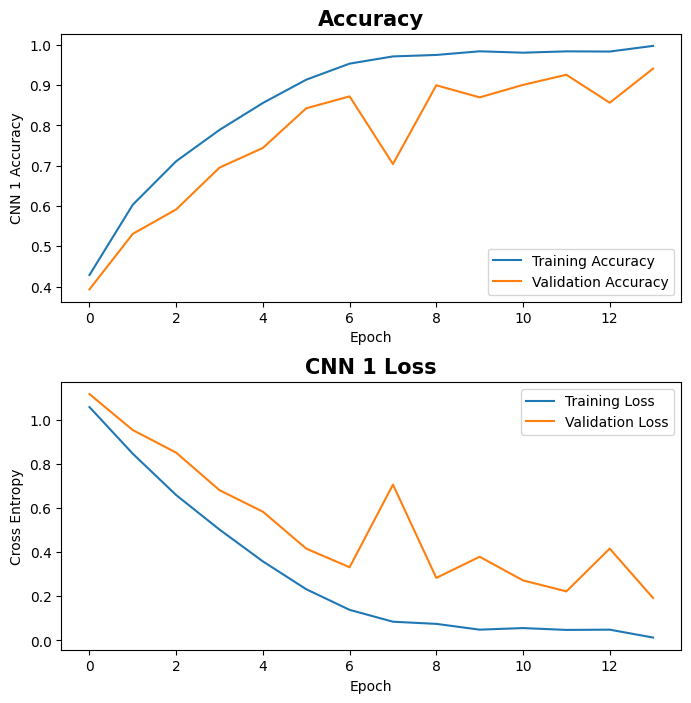

In [19]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('CNN 1 Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')
# plt.savefig('acc_cnn1.png')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('CNN 1 Loss', size=15, fontweight='bold')
# plt.savefig('loss_cnn1.png')

plt.subplots_adjust(hspace=0.3)
plt.show()

In [21]:
acc

[0.42885133624076843,
 0.603355348110199,
 0.7111192941665649,
 0.7888807058334351,
 0.8556820750236511,
 0.9134827256202698,
 0.9532818794250488,
 0.9712221622467041,
 0.974834680557251,
 0.9838966727256775,
 0.9804677963256836,
 0.9837741851806641,
 0.9832843542098999,
 0.9973059296607971]

In [22]:
val_acc

[0.39320865273475647,
 0.5310039520263672,
 0.5915354490280151,
 0.6953740119934082,
 0.7440944910049438,
 0.8425197005271912,
 0.8720472455024719,
 0.7042322754859924,
 0.8996062874794006,
 0.8695865869522095,
 0.9005905389785767,
 0.9256889820098877,
 0.8562992215156555,
 0.9409449100494385]

In [23]:
loss 

[1.0600531101226807,
 0.8479334712028503,
 0.6601668000221252,
 0.5035284757614136,
 0.35894885659217834,
 0.23250848054885864,
 0.13882187008857727,
 0.0849439948797226,
 0.07512865960597992,
 0.04887697845697403,
 0.05608909949660301,
 0.04770169407129288,
 0.04883301258087158,
 0.013015356846153736]

In [24]:
val_loss 

[1.1190606355667114,
 0.9554020762443542,
 0.8530197143554688,
 0.6823475956916809,
 0.5846811532974243,
 0.4170168340206146,
 0.332306832075119,
 0.7077242136001587,
 0.2840728163719177,
 0.37996742129325867,
 0.2726583182811737,
 0.22262755036354065,
 0.4170668423175812,
 0.19255024194717407]

## Testing

In [25]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [27]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

64/64 [==============================] - 1s 20ms/step - loss: 0.2034 - accuracy: 0.9341


{'loss': 0.20336563885211945, 'accuracy': 0.93408203125}

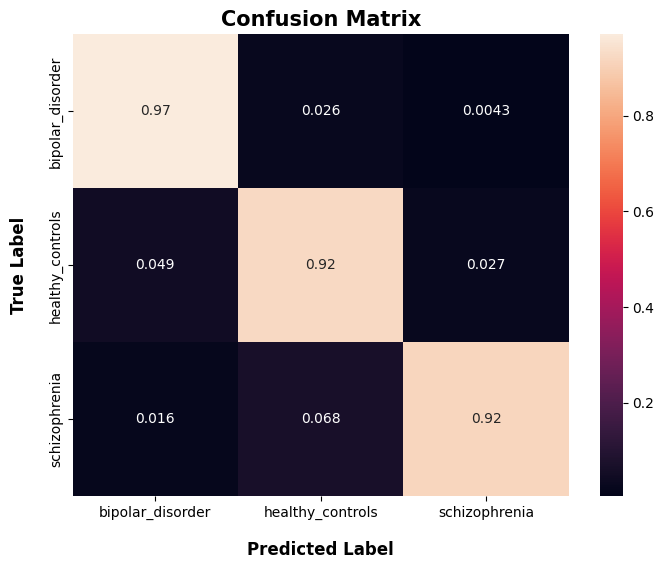

In [30]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN5_cm_dropout01.png')
plt.show()

In [31]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.93408203125
Precision: 0.9377168352162066
Sensitivity: 0.93701171875
Specificity: 0.9683151162842987
